Tf-idf с биграммами и логистическую регрессию поверх этого, свою для каждого класса. И дальше просто для каждого класса в отдельности померить качество (accuracy, f-меру), и глянуть их средние по всем классам.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# Сначала field

Возьмем df с удаленными не-английскими текстами:

In [3]:
df = pd.read_pickle("looong_df_subjects_en.pkl")
df.head()

,DOI,title,abstract,subject,cleaned_abstract,filtered_subject,all_fields,field_Art,field_Biology,field_Business,...,subj_Biological Psychiatry,subj_Gender Studies,"subj_Safety, Risk, Reliability and Quality",subj_Urban Studies,subj_Genetics(clinical),subj_Agricultural and Biological Sciences (miscellaneous),subj_Museology,subj_Nephrology,subj_Logic,lang
0,10.1163/1568525043083505,aristotle fr. 44 rose: midas and silenus,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract scholars have identified two supposed...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
1,10.1163/1568525043083532,loca loquuntur. lucretius' explanation of the ...,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract a discussion of the second part of lu...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
2,10.1163/1568525043083541,poverty and demography: the case of the gracch...,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract according to many ancient historians ...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
3,10.1163/1568525043083514,old persian in athens revisited (ar. ach. 100),<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract the old persian line in aristophanes ...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
4,10.1163/1568527053083412,religion and violence: what can sociology offer?,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Religious studies, History]",abstract this essay presents a sketch of a soc...,"[History, Religious studies]","[Humanities, Humanities]",0,0,0,...,0,0,0,0,0,0,0,0,0,en


In [4]:
target_1 = [column for column in df.columns if "field_" in column]
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_abstract"], df[target_1],
                                                    train_size=0.08, test_size=0.02,
                                                    random_state=42)

In [5]:
y_train_fields = {
    field: y_train[field] for field in target_1
}

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_transformed = vectorizer.fit_transform(X_train)

In [7]:
import threading

svcs = {
    field: CalibratedClassifierCV(
        LinearSVC(random_state=123)
    ) for field in target_1
}

def fit_svc(field, svc):
    print(f'Fitting {field} SVM')
    svc.fit(X_train_transformed, y_train_fields[field])
    print(f'Done fitting {field} SVM')
    # -mt suffix so it doesn't conflict with the first notebook
    filename = f'field_svc_en/{field}-mt.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(svc, f)
    print(f'Saved {filename}')

tasks = []

for field, svc in svcs.items():
    task = threading.Thread(
        target=fit_svc,
        args=(field, svc),
        daemon=True,
    )
    task.start()
    tasks.append(task)

for task in tasks:
    task.join()

Fitting field_Art SVM
Fitting field_Biology SVM
Fitting field_Business SVM
Fitting field_Chemistry SVM
Fitting field_Geology SVM
Fitting field_Humanities SVM
Fitting field_Math SVM
Fitting field_Medicine SVMFitting field_Physics SVM

Fitting field_Psychology SVM
Fitting field_Social SVM
Fitting field_Tech SVM
Done fitting field_Art SVM
Done fitting field_Psychology SVM
Saved field_svc_en/field_Art-mt.pkl
Saved field_svc_en/field_Psychology-mt.pkl
Done fitting field_Math SVM
Done fitting field_Humanities SVM
Saved field_svc_en/field_Math-mt.pkl
Saved field_svc_en/field_Humanities-mt.pkl
Done fitting field_Business SVM
Saved field_svc_en/field_Business-mt.pkl
Done fitting field_Social SVM
Saved field_svc_en/field_Social-mt.pkl
Done fitting field_Geology SVM
Saved field_svc_en/field_Geology-mt.pkl
Done fitting field_Tech SVM
Saved field_svc_en/field_Tech-mt.pkl
Done fitting field_Physics SVM
Saved field_svc_en/field_Physics-mt.pkl
Done fitting field_Chemistry SVM
Saved field_svc_en/field_

In [8]:
X_test_transformed = vectorizer.transform(X_test)

In [9]:
accuracy = {}
recall = {}
precision = {}
f1 = {}

accs = []
recs = []
precs = []
f1s = []

min_positives = np.arange(start=0.05, stop=0.5, step=0.05)
for min_positive in tqdm(min_positives):
    for subj in target_1:
        #print(subj.upper())
        y_pred = svcs[subj].predict_proba(X_test_transformed)
        y_pred = [1 if x[1] > min_positive else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


In [10]:
for field in target_1:
    #print(subj.upper())
    y_pred = svcs[subj].predict(X_test_transformed)
    print(field)
    print(clf_report(y_test[field], y_pred))
    print()

field_Art
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     39256
           1       0.06      0.13      0.08       434

    accuracy                           0.97     39690
   macro avg       0.52      0.55      0.53     39690
weighted avg       0.98      0.97      0.97     39690


field_Biology
              precision    recall  f1-score   support

           0       0.67      0.97      0.79     27012
           1       0.06      0.00      0.01     12678

    accuracy                           0.66     39690
   macro avg       0.37      0.49      0.40     39690
weighted avg       0.48      0.66      0.54     39690


field_Business
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     38528
           1       0.03      0.03      0.03      1162

    accuracy                           0.95     39690
   macro avg       0.50      0.50      0.50     39690
weighted avg       0.94      0.95

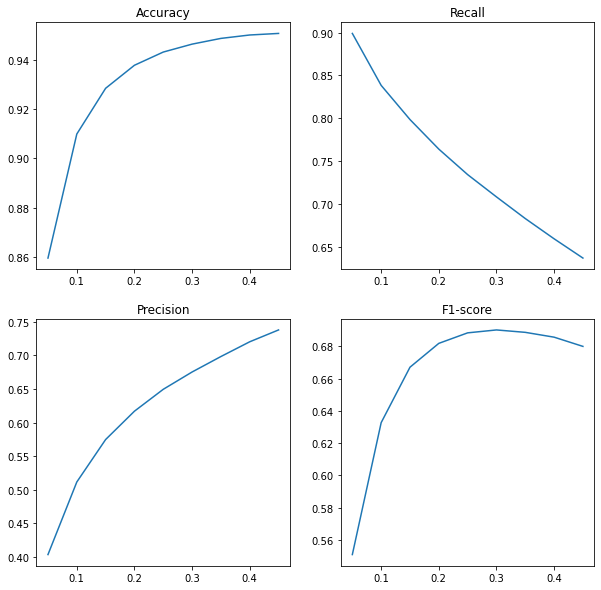

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(min_positives, accs)
axs[0, 0].set_title("Accuracy")

axs[0, 1].plot(min_positives, recs)
axs[0, 1].set_title("Recall")

axs[1, 0].plot(min_positives, precs)
axs[1, 0].set_title("Precision")

axs[1, 1].plot(min_positives, f1s)
axs[1, 1].set_title("F1-score")

plt.show()

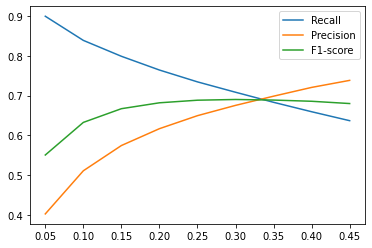

In [12]:
plt.plot(min_positives, recs, label="Recall")
plt.plot(min_positives, precs, label="Precision")
plt.plot(min_positives, f1s, label="F1-score")
plt.legend()
plt.show()

In [13]:
accuracy = {}
recall = {}
precision = {}
f1 = {}

for subj in target_1:
        #print(subj.upper())
        y_pred = svcs[subj].predict_proba(X_test_transformed)
        y_pred = [1 if x[1] > 0.2 else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)

In [14]:
print(f"Average accuracy: {np.mean(list(accuracy.values()))}")
print(f"Average recall: {np.mean(list(recall.values()))}")
print(f"Average precision: {np.mean(list(precision.values()))}")
print(f"Average F1-score: {np.mean(list(f1.values()))}")

Average accuracy: 0.9377509028302677
Average recall: 0.7640338962375949
Average precision: 0.6169322927930233
Average F1-score: 0.681844613591729


# Subject с фичей field

In [15]:
X_test_copy = pd.DataFrame(X_test.copy())

for field in target_1:
    y_pred = svcs[field].predict_proba(X_test_transformed)
    y_pred = [1 if x[1] > 0.2 else 0 for x in y_pred]
    X_test_copy[f"{field}_pred"] = y_pred

In [16]:
X_test_copy.sample(5)

,cleaned_abstract,field_Art_pred,field_Biology_pred,field_Business_pred,field_Chemistry_pred,field_Geology_pred,field_Humanities_pred,field_Math_pred,field_Medicine_pred,field_Physics_pred,field_Psychology_pred,field_Social_pred,field_Tech_pred
2169349,recent developments of two color operation mod...,0,1,0,1,0,0,0,0,1,0,0,1
2127117,abstract a previously described clin chem 18 7...,0,1,0,1,0,0,0,0,0,0,0,0
1814592,abstract several aspects of the integration of...,0,0,0,0,0,0,0,0,1,0,0,0
636757,the numerical simulation was carried out to in...,0,0,0,0,0,0,0,0,1,0,0,0
1857615,we proceed towards an application of the mathe...,0,0,0,0,0,0,1,0,1,1,0,0


И начинаем предсказывать сабжекты:

In [17]:
target_2 = [column for column in df.columns if "subj_" in column]
X_train, X_test, y_train, y_test = train_test_split(df[["cleaned_abstract"] + target_1], df[target_2],
                                                    train_size=0.08, test_size=0.02,
                                                    random_state=42)

In [18]:
y_train_subjs = {
    subj: y_train[subj] for subj in target_2
}

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_transformed = vectorizer.fit_transform(X_train["cleaned_abstract"])

In [20]:
from scipy import sparse

X_train_stacked = sparse.hstack((
    X_train_transformed,
    sparse.csr_matrix(X_train[target_1])
))

In [ ]:
import threading
from tqdm import tqdm

def fit_svc(field, svc):
    #print(f'Fitting {field} SVM')
    svc.fit(X_train_stacked, y_train_subjs[field])
    #print(f'Done fitting {field} SVM')
    # -mt suffix so it doesn't conflict with the first notebook
    filename = f'subj_svc_en/{field}-mt.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(svc, f)
    print(f'Saved {filename}')


tasks = []

subj_svcs = {
    subj: CalibratedClassifierCV(
        LinearSVC(random_state=123)
    ) for subj in target_2
}

for subj, svc in tqdm(subj_svcs.items()):
    task = threading.Thread(
        target=fit_svc,
        args=(subj, svc),
        daemon=True,
    )
    task.start()
    tasks.append(task)

for task in tasks:
    task.join()

100%|██████████| 200/200 [12:00<00:00,  3.60s/it]


In [ ]:
X_test_transformed.shape, X_train_transformed.shape

In [ ]:
X_test_stacked.shape, X_train_stacked.shape

In [26]:
X_test_transformed = vectorizer.transform(X_test["cleaned_abstract"])

X_test_stacked = sparse.hstack((
    X_test_transformed,
    sparse.csr_matrix(X_test[target_1])
))

In [31]:
from tqdm.notebook import tqdm


accuracy = {}
recall = {}
precision = {}
f1 = {}

accs = []
recs = []
precs = []
f1s = []

min_positives = np.arange(start=0.05, stop=0.5, step=0.05)
for min_positive in tqdm(min_positives):
    for subj in tqdm(target_2):
        y_pred = subj_svcs[subj].predict_proba(X_test_stacked)

        y_pred = [1 if x[1] > min_positive else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

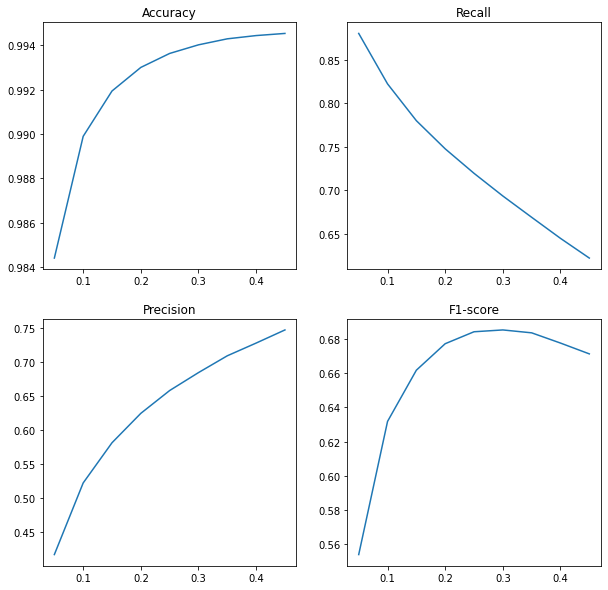

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(min_positives, accs)
axs[0, 0].set_title("Accuracy")

axs[0, 1].plot(min_positives, recs)
axs[0, 1].set_title("Recall")

axs[1, 0].plot(min_positives, precs)
axs[1, 0].set_title("Precision")

axs[1, 1].plot(min_positives, f1s)
axs[1, 1].set_title("F1-score")

plt.show()

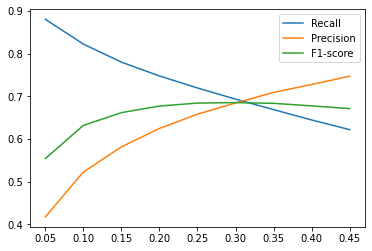

In [33]:
plt.plot(min_positives, recs, label="Recall")
plt.plot(min_positives, precs, label="Precision")
plt.plot(min_positives, f1s, label="F1-score")
plt.legend()
plt.show()

In [34]:
min_positive

0.45

In [35]:
print(f"Average accuracy: {np.mean(list(accuracy.values()))}")
print(f"Average recall: {np.mean(list(recall.values()))}")
print(f"Average precision: {np.mean(list(precision.values()))}")
print(f"Average F1-score: {np.mean(list(f1.values()))}")

Average accuracy: 0.9945287226001511
Average recall: 0.6219216210245879
Average precision: 0.7469243499789894
Average F1-score: 0.6712064898485999


In [38]:
for subj in tqdm(target_2):
    y_pred = subj_svcs[subj].predict_proba(X_test_stacked)

    y_pred = [1 if x[1] > 0.2 else 0 for x in y_pred]
    accuracy[subj] = accuracy_score(y_test[subj], y_pred)
    recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
    precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
    f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
print(f"Average accuracy: {np.mean(list(accuracy.values()))}")
print(f"Average recall: {np.mean(list(recall.values()))}")
print(f"Average precision: {np.mean(list(precision.values()))}")
print(f"Average F1-score: {np.mean(list(f1.values()))}")

Average accuracy: 0.9929981103552532
Average recall: 0.7475783421311931
Average precision: 0.6246624569967958
Average F1-score: 0.6771389076524315
